In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
get_ipython().magic(u'matplotlib inline')

version = 0.1

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [59]:
# it seems that PassengerId, Name, Ticket, Cabin aren't very useful, drop them for now
df.drop(['PassengerId','Name','Ticket','Cabin'], inplace=True, axis=1)

In [60]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114833050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114b77d90>]], dtype=object)

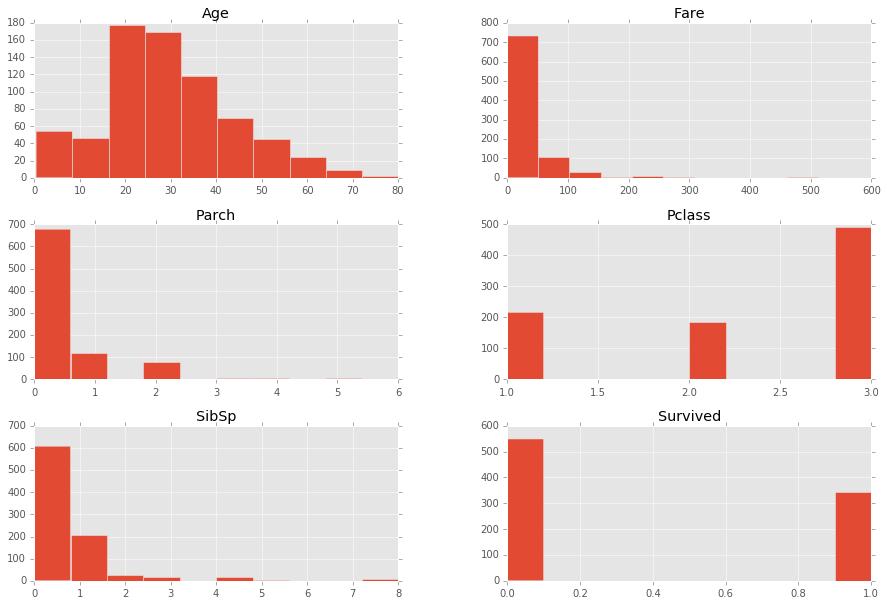

In [61]:
# there are some missing values in Age. But first check the distribution with histogram
df.hist(figsize=(15,10
                ))

In [62]:
# df.plot(kind='box', return_type='dict' , subplots = True, figsize=(15,5))

In [63]:
# fill the missing values in Age
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace = True)

In [64]:
# first convert to str, then map to 1,0
df.Sex = df.Sex.astype(str).map({'male':1,'female':0})

In [65]:
df.apply(lambda x: x.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [66]:
df[df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,0,38.0,0,0,80.0,NaN
829,1,1,0,62.0,0,0,80.0,NaN


In [67]:
# check Embarked values
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

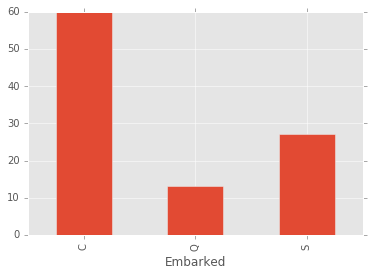

In [68]:
df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [69]:
# it seems that based on Fare-Embarked relation, the missing values are likely C.
df.Embarked.fillna('C', inplace=True)

In [70]:
df.Embarked = df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [71]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [72]:
#df['FamilySize'] = df.SibSp + df.Parch
#df.drop(['SibSp','Parch'],axis=1, inplace=True)

In [73]:
df.columns

Index([u'Survived', u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
       u'Embarked', u'FamilySize'],
      dtype='object')

In [74]:
predictor_var = list(df.columns[1:]) ;predictor_var
outcome_var = 'Survived'

In [75]:
categorical = ['Pclass', 'Sex','Embarked']
non_categorical = [ i for i in predictor_var if i not in categorical ]

In [76]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = ohe.fit_transform(df[categorical])

In [77]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_non_cat = sc.fit_transform(df[non_categorical])

In [78]:
from numpy import hstack
X = hstack((X_non_cat, X_cat))
y = df[outcome_var]
X.shape, X_non_cat.shape, X_cat.shape

((891, 13), (891, 5), (891, 8))

In [79]:
# now let's pick some models to predict loan status

#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics


#Generic function for making a classification model and accessing performance:
def classification_model(model, X, y, cv=10):
  #Fit the model:
  model.fit(X,y)
  
  #Make predictions on training set:
  predictions = model.predict(X)
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,y)
  print "Accuracy : %s" % "{0:.3%}".format(accuracy)

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(X.shape[0], n_folds=cv)
  error = []
  for train, test in kf:
    # Filter training data
    #train_predictors = (X.iloc[train,:])
    # sparse matrix need call tocsc before indexing.
    #train_predictors = X.tocsc()[train,:]
    train_predictors = (X[train,:])
    
    # The target we're using to train the algorithm.
    train_target = y.iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    #error.append(model.score(X.iloc[test,:], y.iloc[test]))
    #error.append(model.score(X.tocsc()[test,:], y.iloc[test]))
    error.append(model.score(X[test,:], y.iloc[test]))
 
  print "Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error))

  #Fit the model again so that it can be refered outside the function:
  model.fit(X,y) 

In [80]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/modules/generated\
#/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [81]:
lr_model = LogisticRegression()
classification_model(lr_model, X, y)

Accuracy : 80.584%
Cross-Validation Score : 80.025%


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

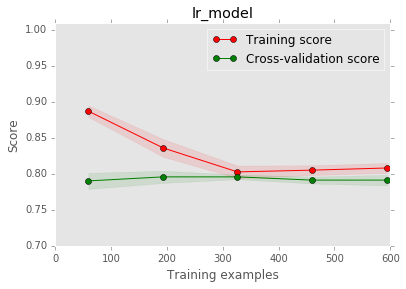

In [82]:
plot_learning_curve(lr_model, "lr_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [83]:
dt_model = DecisionTreeClassifier(max_depth=4)
classification_model(dt_model, X,y)
print dt_model.tree_.node_count

Accuracy : 83.502%
Cross-Validation Score : 80.258%
29


In [114]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=6)
classification_model(rf_model, X,y)

Accuracy : 86.195%
Cross-Validation Score : 83.170%


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

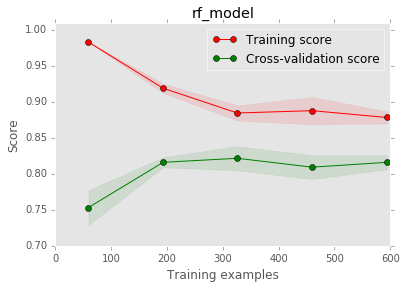

In [115]:
plot_learning_curve(rf_model, "rf_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [85]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=1)
classification_model(svm_model, X,y)

Accuracy : 83.389%
Cross-Validation Score : 82.382%


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

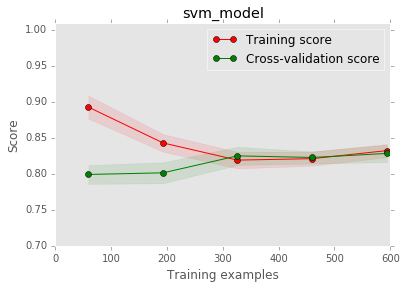

In [108]:
plot_learning_curve(svm_model, "svm_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [107]:
"""
from sklearn.grid_search import GridSearchCV   #Perforing grid search

param_test1 = {
    #'C':(1e-5,1e-2,1,10), C=1, .826
    #'gamma':(.9,.6,.3,.1), gamma = .1
}

gsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch1.fit(X, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
"""

"\nfrom sklearn.grid_search import GridSearchCV   #Perforing grid search\n\nparam_test1 = {\n    #'C':(1e-5,1e-2,1,10), C=1, .826\n    #'gamma':(.9,.6,.3,.1), gamma = .1\n}\n\ngsearch1 = GridSearchCV(estimator = svm.SVC(kernel='rbf', random_state=0, gamma=.1), \n param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)\n\ngsearch1.fit(X, y)\ngsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_\n"

[0]	train-error:0.266573	test-error:0.317978
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 10 rounds.
[1]	train-error:0.212921	test-error:0.264045
[2]	train-error:0.158989	test-error:0.194382
[3]	train-error:0.152247	test-error:0.197753
[4]	train-error:0.151404	test-error:0.198876
[5]	train-error:0.147191	test-error:0.195505
[6]	train-error:0.145224	test-error:0.193258
[7]	train-error:0.14073	test-error:0.18764
[8]	train-error:0.137078	test-error:0.191011
[9]	train-error:0.13455	test-error:0.189887
[10]	train-error:0.133708	test-error:0.184269
[11]	train-error:0.132303	test-error:0.191011
[12]	train-error:0.132022	test-error:0.189887
[13]	train-error:0.130337	test-error:0.186517
[14]	train-error:0.128651	test-error:0.188764
[15]	train-error:0.129213	test-error:0.189887
[16]	train-error:0.129213	test-error:0.189887
[17]	train-error:0.127528	test-error:0.189887
[18]	train-error:0.124719	test-error:0.1

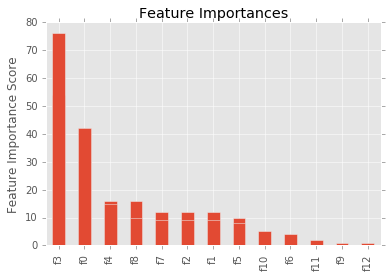

In [86]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.cross_validation import train_test_split

def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = xgb.DMatrix(X,label=y)
        cvresult = xgb.cv(xgb_param,
                          dtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error', # no accuracy
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                                     xgb.callback.early_stop(early_stopping_rounds)]
                         )
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
modelfit(xgb1, df[predictor_var], df[outcome_var])


#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=42)
modelfit(xgb1, X, y)

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

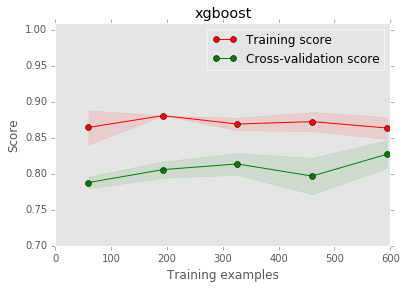

In [87]:
plot_learning_curve(xgb1, "xgboost", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [88]:
# now work on test data
test_df.apply(lambda x: x.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [89]:
test_df.drop(['Ticket','Cabin'],inplace=True, axis=1)

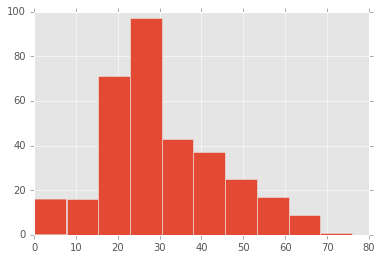

In [90]:
test_df.Age.hist()

In [91]:
test_df.Age.fillna(test_df.Age.median(), inplace=True)

In [92]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


In [93]:
test_df.Embarked = test_df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [94]:
test_df.Sex = test_df.Sex.astype(str).map({'male':1,'female':0})

In [95]:
mean_fare = test_df[test_df.Embarked==0]['Fare'].mean() ; mean_fare

28.230436431226767

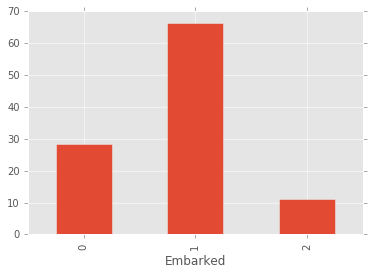

In [96]:
test_df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [97]:
test_df.Fare.fillna(mean_fare, inplace = True)

In [98]:
#test_df['FamilySize'] = test_df.SibSp + test_df.Parch

In [99]:
# encoding, standarize
X_test_cat = ohe.fit_transform(test_df[categorical])
X_test_non_cat = sc.fit_transform(test_df[non_categorical])
X_test = hstack((X_test_non_cat, X_test_cat))

In [116]:
Y_pred = rf_model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submissions/rf2.csv', index=False)

In [101]:
# SVM1: .79426
# SVM2: .78469. use FamilySize instead of SibSp, Parch
# SVM3: .79426. Use both. no improvement
# xgb1, rf1 : not as good as svm1
# dt1,  .76077
# lr1: .76077, trees = 100, depth = 5
# rf2: .77512, n_estimator=300, maxdepth = 6